# Qiskit Workshop: Dynamic Circuits

Dynamic circuits allow you to take mid-circuit measurements of qubits, then take actions in the remainder of the circuit based on the outcome of that measurement. This feature can be used to contruct new types of quantum algorithms (e.g. the Iterative Quantum Phase Estimation algorithm), to allow for classical communication between different quantum processors, and to implement quantum error correction codes.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
import numpy as np

In [3]:
from qiskit_aer import AerSimulator

backend = AerSimulator()

## Basics

Let's construct a simple dynamic circuit to show what you can do. The key function to use is `if_test()` of a `QuantumCircuit` object.

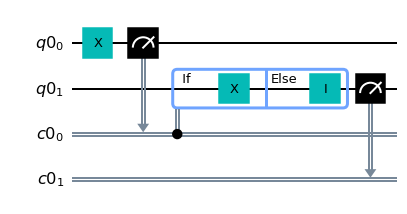

In [4]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)

# Comment/Uncomment this line to see what happens!
qc.x(qr[0])

qc.measure(qr[0], cr[0])

# If the measurement outcome is 1, apply an X gate to the second qubit
with qc.if_test((cr[0], 1)) as else_:
    qc.x(qr[1])
# otherwise, just apply the identiy gate to the second qubit (i.e. do nothing)
with else_:
    qc.id(qr[1])

qc.measure(qr[1], cr[1])

qc.draw()

In [5]:
job = backend.run(qc)
counts = job.result().get_counts()
counts

{'11': 1024}

## Example: Quantum Teleportation

One of the rules of quantum computing is that it is not possible to copy or "clone" the state of a qubit. This is the no-cloning rule. However, it is possible to "teleport" the state of one qubit to another. Doing so requires at least three qubits: 1) the source qubit with the state to teleport, and 2-3) an entangled pair of qubits, such as a Bell state. The state of the source qubit will be teleported to the second qubit of the Bell pair. The teleportation protocol works as follows:

1. Prepare a Bell state pair.
1. Entangle the source qubit to the first qubit of the Bell pair.
1. Apply a Hadamard gate on the source qubit to change the measurement basis.
1. Measure the both the source qubit and the first qubit of the Bell pair.
1. Depending on the outcome of the measurements, apply gates to the second qubit of the Bell pair to correct its state.

In [6]:
psi = QuantumRegister(1, name='psi')
bell_pair = QuantumRegister(2, name='bell')
cr = ClassicalRegister(2, name='c')
c_result = ClassicalRegister(1, 'result')
qc = QuantumCircuit(psi, bell_pair, cr, c_result)

First, prepare a state $|\psi\rangle$ on the first qubit `psi` (i.e. our source qubit). For simplicity, we simply rotate the qubit state using a Y Rotation gate with an angle of $2\pi/3$

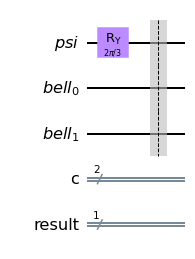

In [7]:
# Prepare state on the source qubit
qc.ry(np.pi*2/3, psi)
qc.barrier()
qc.draw()

Next, create an entangled Bell state pair

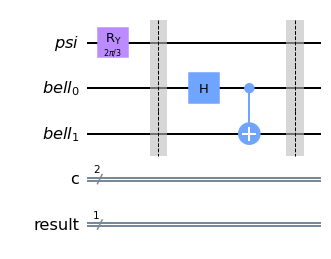

In [8]:
qc.h(bell_pair[0])
qc.cx(bell_pair[0], bell_pair[1])
qc.barrier()
qc.draw()

Now, prepare qubits `psi` and `bell_pair[0]` for measurement

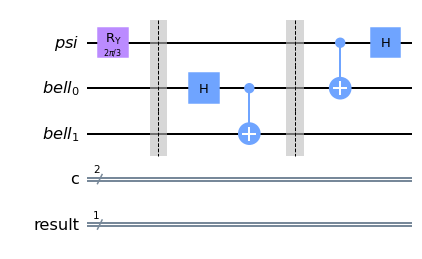

In [9]:
qc.cx(psi, bell_pair[0])
qc.h(psi)
qc.draw()

Measure qubit `psi` and `bell_pair[0]`

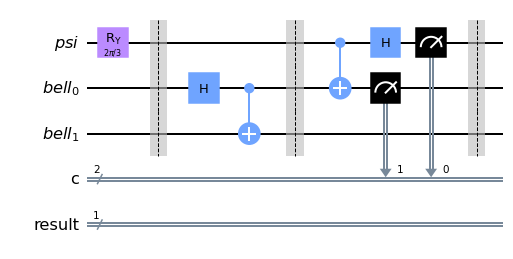

In [10]:
# Measure psi and bell_pair[0]
qc.measure([psi[0], bell_pair[0]], [cr[0], cr[1]])
qc.barrier()
qc.draw()

Due to the entanglement of the Bell pair, information on the state of `psi` has been teleported to qubit `bell_pair[1]`. However, it is not necessarily exactly in the same state as `psi` was. We need to make corrections to the state of `bell_pair[1]` by using information from the measured qubits. For this, we use Dynamic Circuits to control which corrective gates to apply.

In [11]:
# Dynamic circuit to correct state of bell_pair[1]
with qc.if_test((cr[1], 1)):
    qc.x(bell_pair[1])
    
with qc.if_test((cr[0], 1)):
    qc.z(bell_pair[1])

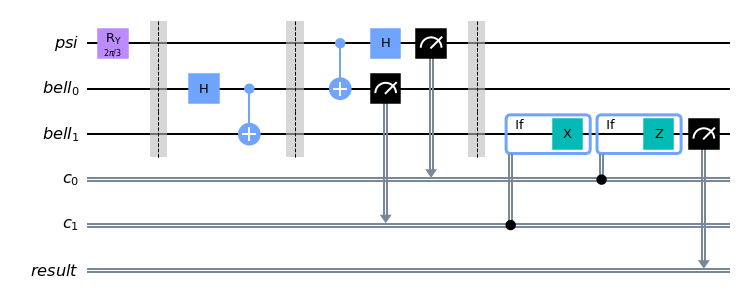

In [12]:
# Measure the output of bell_pair[1]
qc.measure(bell_pair[1], c_result)
qc.draw()

Run the circuit in the simulator

In [13]:
from qiskit.result import marginal_counts

job = backend.run(qc, shots=1000)
raw_result = job.result()
result = marginal_counts(raw_result, indices=[2])
counts = result.get_counts()
counts

{'0': 254, '1': 746}

Check the original state of the `psi` qubit by running the original circuit that prepared $|\psi\rangle$

{'0': 262, '1': 738}


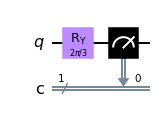

In [14]:
# Construct the original state preparation circuit
qc_check_state = QuantumCircuit(1, 1)
qc_check_state.ry(np.pi*2/3, 0)
qc_check_state.measure(0, 0)

# Run on the simulator and print the results
job = backend.run(qc_check_state, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
qc_check_state.draw()

In [15]:
%qiskit_version_table